#### Introduction
Before the analysis can begin, it is important to ensure that the data is
reliable and sufficiently extensive. Here the 'UKBMS site location data 2023' is 
checked through a series of exploratory and filtering operations. 

#### Workflow
1) Extra spaces are removed.
2) Duplicated rows are removed.
3) Null values are identified and the source investigated.
4) Null values are grouped by year and gridreference. This is to see if nulls can be 
attributed to a particular group. 
5) Redundant columns are removed.

In [1]:
# Importing packages
import pandas as pd
import os
from pathlib import Path

# Importing localised file directory
project_root = Path(os.environ['butterfly_project'])

# Importing dataset
site_location = pd.read_csv(
    project_root/'Data'/'UKBMS'/'ukbms_site_location_data'/'ukbmssitelocationdata2023.csv', encoding='cp1252'
)

#### Removing Extra Spaces

In [85]:
# Start and end spaces
site_location_spaces = (
    site_location.copy()
    .apply(lambda x: x.str.strip() # .strip() removes spaces at start and end of string
           if x.dtype=='object' else x) # operation only applied to 'non numeric' values
)

# Removing 2 or more consecutive spaces
site_location_spaces = (
    site_location_spaces
    # replaces 2 or more spaces with single space
    .apply(lambda x: x.str.replace(' {2,}', ' ') if x.dtype=='object' 
           else x) # operation only applied to 'non numeric' values
)

#### Duplicated Rows

In [86]:
# Grouping by site number
site_location_number_duplicate = (
    site_location_spaces
    .groupby(['Site_Number']) # grouping rows by site number (should be unique).
    .agg(count=('Site_Number','count')) # counting the number of duplicates
    .sort_values('count', ascending=False) # descending order of counts
)

# Checking for duplicated site numbers
if site_location_number_duplicate.iloc[0,0]>1: # Are any site numbers duplicated? 
    print(site_location_number_duplicate.head()) # Preview of duplicated records
else:
    print('No duplicate site numbers exist') # otherwise confirm there are no duplicates

No duplicate site numbers exist


In [87]:
# Grouping by site name
site_location_name_duplicate = (
    site_location_spaces
    # Different surveys use the same site name, so must group using several variables to 
    # identify duplicate entries
    .groupby(['Site_Name',
              'Gridreference',
              'First_year_surveyed'])
    .agg(count=('Site_Name','count')) # grouping rows by site name (should be unique)
    .sort_values('count', ascending=False) # descending order of counts
)

# Checking for duplicated site names  
if site_location_name_duplicate.iloc[0,0]>1: # Are any site names duplicated?
    print(duplicate_site_name.head()) # Preview of duplicated records
else:
    print('No duplicate survey names exist') # otherwise confirm there are no duplicates

No duplicate survey names exist


#### Investigating Null Values

In [89]:
# Grouping null values by survey type
print(
    site_location_spaces
    .groupby('Survey_type') 
    .agg({lambda x: x .isna().sum()}) # sum null values across rows for each grouping
)

# While 'Length' and 'N_sections' columns are not important for the analysis, they may
# point towards to unreliable data. For this reason it is important to investigate the 
# source and identify any patterns. The nulls values may be attributed to the year or 
# location where the surveys were taken.

            Site_Number Site_Name Gridreference  Easting Northing   Length  \
               <lambda>  <lambda>      <lambda> <lambda> <lambda> <lambda>   
Survey_type                                                                  
UKBMS                 0         0             0        0        0      238   
WCBS                  0      2322             0        0        0      929   

             Country N_sections N_yrs_surveyed First_year_surveyed  \
            <lambda>   <lambda>       <lambda>            <lambda>   
Survey_type                                                          
UKBMS              0         95              0                   0   
WCBS               0        393              0                   0   

            Last_year_surveyed  
                      <lambda>  
Survey_type                     
UKBMS                        0  
WCBS                         0  


#### Investigating 'Length' and 'N-sections' nulls in UKBMS surveys
Are nulls linked to survey area?

In [90]:
# Filtering to UKBMS surveys only
site_location_ukbms = (
    site_location_spaces[
    site_location_spaces['Survey_type'].isin(['UKBMS']) # boolean column 
    ]
)

# Finding rows where null values exist (returning boolean column)
ukbms_nulls = (
    site_location_ukbms.isna()
    .any(axis=1) # looks across all columns, returning rows if nulls are detected
)

# Investigating source of 'length' and 'n-sections' nulls
ukbms_sites_suspicious = (
    # Are nulls clustered by grid reference?
    site_location_ukbms[ukbms_nulls]['Gridreference'] 
    # counts instances where nulls appear in a gridreference
    .value_counts(ascending=False) 
)

# Is there a single gridreference linked to more than 5 null rows?
if ukbms_sites_suspicious.iloc[0]>5: 
    print(ukbms_sites_suspicious.head()) # Preview of null rows
else:
    # confirm gridreference not linked
    print('GRID REFERENCES NOT LINKED TO NULL ENTRIES') 

GRID REFERENCES NOT LINKED TO NULL ENTRIES


#### Investigating 'Length' and 'N-sections' Nulls in UKBMS Surveys
Are nulls linked to study year?

<Figure size 640x480 with 0 Axes>

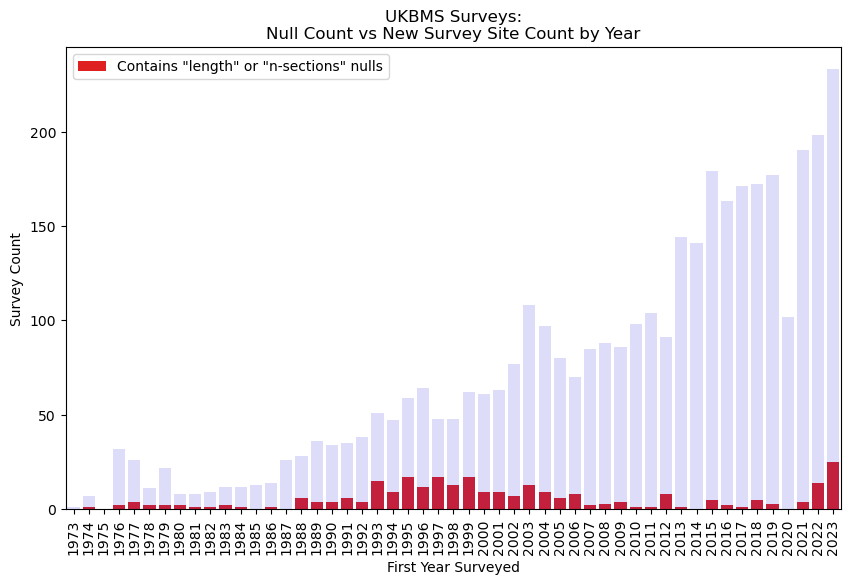

In [91]:
# Preparing the data for visualisation

# Assigning the x variable
years_ukbms = range(1973,2024)

# Assigning the y variable for all rows
count_ukbms = (
    site_location_ukbms['First_year_surveyed']
    .value_counts() # groups by 'first_year_surveyed'
)

count_ukbms = (
    count_ukbms
    # some years were not surveyed. To visualise clearly, zero value rows are 
    # created for these years. This means an empty year will appear on the x-axis.
    .reindex(years_ukbms, fill_value=0)
)

# Assigning the y variable for rows where nulls exist
null_count_ukbms = (
    site_location_ukbms[ukbms_nulls] # boolean filter only returns null rows
    ['First_year_surveyed'].value_counts() # groups by 'first_year_surveyed'
)

null_count_ukbms = (
    null_count_ukbms
    # some years have no null entries. To visualise clearly, zero value rows are 
    # created for these years. This means an empty year will appear on the x-axis.
    .reindex(years_ukbms, fill_value=0) 
)

# Visualising the data

# Importing the required packages
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf() # clears the previous plot

# Adjusting the plot size
fig, ax = plt.subplots(figsize=(10,6)) # must be entered before seborn code

# Rows where null values were entered
sns.barplot(x=years_ukbms,
           y=null_count_ukbms,
           color='red',
           label='Contains "length" or "n-sections" nulls')

# All rows
sns.barplot(x=years_ukbms,
           y=count_ukbms,
           color='blue',
           alpha=0.15) # adjusting the transparency/intensity of color

plt.title('UKBMS Surveys:\nNull Count vs New Survey Site Count by Year')
plt.xlabel('First Year Surveyed') 
plt.ylabel('Survey Count')
plt.xticks(rotation=90) # rotates the x labels 90 degrees
plt.legend() # creates legend for all 'labels' defined in seaborn code chunk. 

plt.show()

# Conclusion: there are no obvious patterns between null count and year. 

#### Investigating 'Length' and 'N-sections' nulls in WCBS Surveys
Are the nulls linked to survey area? 

In [92]:
# Filtering to WCBS surveys only
site_location_wcbs = (
    site_location_spaces[
    site_location_spaces['Survey_type'].isin(['WCBS']) # boolean column 
    ]
)

# Finding rows where null values exist (returning boolean column)
wcbs_nulls = (
    site_location_wcbs
    # Null exists in every name row, so column must be removed.
    .drop(columns=['Site_Name'])
    .isna()
    .any(axis=1) # looks across all columns, returning rows if nulls are detected
)

# Investigating source of 'length' and 'n-sections' nulls
wcbs_sites_suspicious = (
    # Are nulls clustered by grid reference?
    site_location_wcbs[wcbs_nulls]['Gridreference'] 
    # counts instances where nulls appear in a gridreference
    .value_counts(ascending=False) 
)

# Is there a single gridreference linked to more than 5 null rows?
if wcbs_sites_suspicious.iloc[0]>5: 
    print(wcbs_sites_suspicious.head()) # Preview of null rows
else:
    # confirm gridreference not linked
    print('GRID REFERENCES NOT LINKED TO NULL ENTRIES') 

GRID REFERENCES NOT LINKED TO NULL ENTRIES


#### Investigating 'Length' and 'N-sections' Nulls in WCBS surveys
Are nulls linked to study year?

<Figure size 640x480 with 0 Axes>

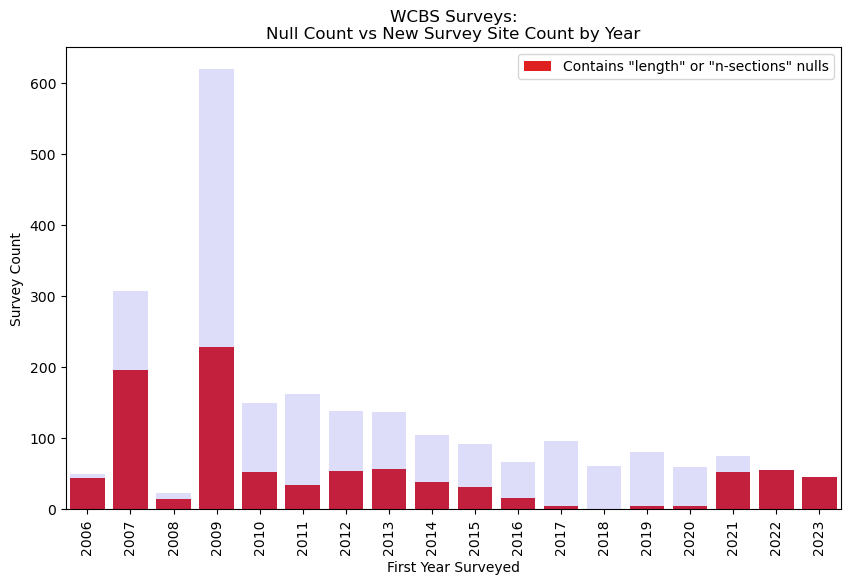

In [95]:
# Are 'length' and 'n-sections' nulls attributed to a particular year?
# WCBS survey analysis

# Preparing the data for visualisation

# Assigning the x variable
years_wcbs = range(2006, 2024) # wcbs surveys started in 2006, later than ukbms

# Assigning the y variable for all rows
count_wcbs = (
    site_location_wcbs['First_year_surveyed']
    .value_counts() # groups by 'first_year_surveyed'
)

count_wcbs = (
    count_wcbs
    # some years were not surveyed. To visualise clearly, zero value rows are 
    # created for these years. This means an empty year will appear on the x-axis.
    .reindex(years_wcbs, fill_value=0)
)

# Assigning the y variable for rows where nulls exist

null_count_wcbs = (
    site_location_wcbs[wcbs_nulls] # boolean filter only returns null rows
    ['First_year_surveyed'].value_counts() # groups by 'first_year_surveyed'
)

null_count_wcbs = (
    null_count_wcbs
    # some years have no null entries. To visualise clearly, zero value rows are 
    # created for these years. This means an empty year will appear on the x-axis.
    .reindex(years_wcbs, fill_value=0) 
)

# Visualising the data

plt.clf() # clears the previous plot

# Adjusting the plot size
fig, ax = plt.subplots(figsize=(10,6)) # must be entered before seborn code

# Rows where null values were entered
sns.barplot(x=years_wcbs,
           y=null_count_wcbs,
           color='red',
           label='Contains "length" or "n-sections" nulls')

# All rows
sns.barplot(x=years_wcbs,
           y=count_wcbs,
           color='blue',
           alpha=0.15) # adjusting the transparency/intensity of color

plt.title('WCBS Surveys:\nNull Count vs New Survey Site Count by Year')
plt.xlabel('First Year Surveyed') 
plt.ylabel('Survey Count')
plt.xticks(rotation=90) # rotates the x labels 90 degrees
plt.legend() # creates legend for all 'labels' defined in seaborn code chunk. 

plt.show()

# Conclusion: there are no obvious patterns between null count and year. 

#### Removing Redundant Columns

In [96]:
ukbms_site_location_cleaned_v1 = (
    site_location_spaces
    .drop(columns=['N_sections',
                   'Length',
                   'N_yrs_surveyed',
                   'First_year_surveyed',
                   'Last_year_surveyed'])
)

In [47]:
# Saving data frame as csv file
ukbms_site_location_cleaned_v1.to_csv(project_root/'Data'/'UKBMS'/'ukbms_site_location_data'/'ukbms_site_location_cleaned_v1')